# PyTorch - Model Building Blocks

This notebook covers the building blocks required to build a model.

Models are defined using the nn.Module class. This class provides all the necessary structure to build Neural Networks. To create your model, you inherit from the nn.Module class, overloading the required methods. 

These are two key functions that you need to define:
- `__init__` Method: Class constructor where we define the layers.
- `forward` Method: Define how the layers are connected to each other. This is done by establishing how a forward pass would work, from the input data to the predicted output.

# 0. Imports, Constants and Support Functions

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler

In [2]:
CONFIG = {"seed": 14}

# 1. Generate a Toy Dataset

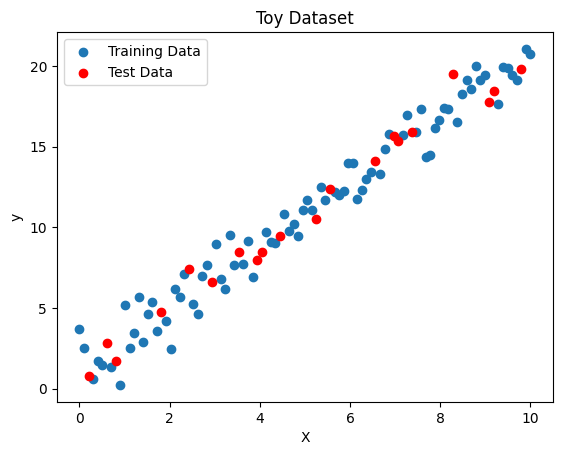

In [3]:
# Generate a simple regression model with noise
X = torch.linspace(0, 10, 100).reshape(-1, 1)
y = 2 * X + 1 + torch.randn(X.size())

# Split between Train and Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=CONFIG["seed"]
)

# Plot training and test dataset
plt.scatter(x=X_train, y=y_train, label="Training Data")
plt.scatter(x=X_test, y=y_test, label="Test Data", color="red")
plt.xlabel("X")
plt.ylabel("y")
plt.title("Toy Dataset")
plt.legend()

# 2. Generate your model

This is how you define a really simple model and use it untrained.

In [4]:
class LRModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        # Start base class
        super(LRModel, self).__init__()

        # Define linear regression
        self.linear = nn.Linear(in_features=input_dim, out_features=output_dim)

    def forward(self, x):
        return self.linear(x)

In [5]:
# Define parameters
input_dim = 1
output_dim = 1

# Instantiate class
lr_model = LRModel(input_dim=input_dim, output_dim=output_dim)

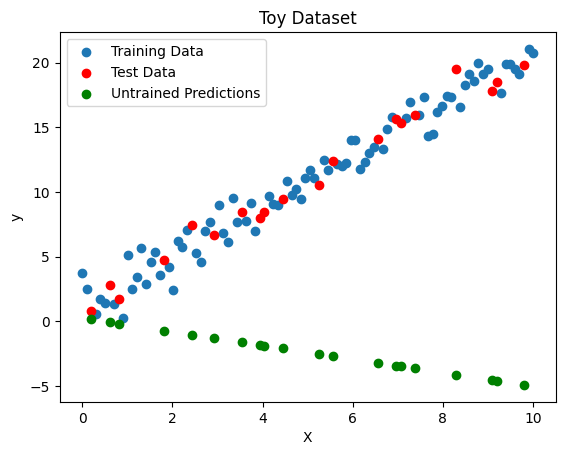

In [6]:
# Predict without training
with torch.no_grad():
    y_untrained = lr_model(X_test)

# Plot training and test dataset
plt.scatter(x=X_train, y=y_train, label="Training Data")
plt.scatter(x=X_test, y=y_test, label="Test Data", color="red")
plt.scatter(x=X_test, y=y_untrained, label="Untrained Predictions", color="green")
plt.xlabel("X")
plt.ylabel("y")
plt.title("Toy Dataset")
plt.legend()

# 3. Training your model

The previous performance is pretty abysmal, so we would like to fit our model to the training data. 

To do this, we need to define:
- Loss function: The function to optimize, telling the model "how wrong it is". 
    - In this case, we will use Mean Square Error (MSE), as we are facing a Regression task. 
    - Binary Classification: Use BCEWithLogitsLoss or BCELoss.
    - Multi-Class Classification: Use CrossEntropyLoss or NLLLoss.
    - Multi-Label Classification (where an input can belong to multiple classes): Use BCELoss or BCEWithLogitsLoss but ensure the output layer handles multi-label scenarios (e.g., multiple Sigmoids instead of a Softmax).
- Optimizer: Algorithms that will tune the network parameters to minimize the loss function. Common optimizers are Stochastic Gradient Descent (SGD) or Adam.
- Epochs: Number of times our dataset is used to train the data.

The training loop is the process of repeatedly passing the training data through the model to update the model parameters. The usual steps of this training loop are the following:
- **Forward Pass**: Compute output by passing an input sample through the defined network. 
- **Calculate Loss**: Compare label with predicted output and calculate loss.
- **Backward Pass**: Backpropagate the loss calculating the gradients.
- **Update Parameters**: Adjust the model parameters using the optimizer.

In [7]:
# Define training parameters
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lr_model.parameters(), lr=0.05)
num_epochs = 31

In [8]:
# Set the model in training mode
lr_model.train()

# Define logging variables
loss_values = []

# Define training loop
for epoch in range(num_epochs):
    # Reset gradient after each iteration
    optimizer.zero_grad()

    # Forward pass
    prediction = lr_model(X_train)

    # Calculate loss
    loss = criterion(prediction, y_train)

    # Calculate gradients
    loss.backward()

    # Update parameters
    optimizer.step()

    # Append loss values
    loss_values.append(loss.item())

    # Print loss every 5 epochs
    if epoch % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/31], Loss: 231.2322
Epoch [6/31], Loss: 183.5716
Epoch [11/31], Loss: 141.9499
Epoch [16/31], Loss: 106.5948
Epoch [21/31], Loss: 77.4880
Epoch [26/31], Loss: 54.3536
Epoch [31/31], Loss: 36.6786


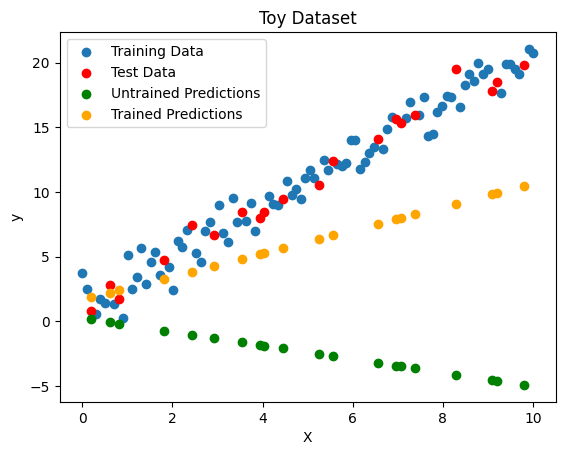

In [9]:
# Predict after training training
lr_model.eval()
with torch.no_grad():
    y_trained = lr_model(X_test)

# Plot training and test dataset
plt.scatter(x=X_train, y=y_train, label="Training Data")
plt.scatter(x=X_test, y=y_test, label="Test Data", color="red")
plt.scatter(x=X_test, y=y_untrained, label="Untrained Predictions", color="green")
plt.scatter(x=X_test, y=y_trained, label="Trained Predictions", color="orange")
plt.xlabel("X")
plt.ylabel("y")
plt.title("Toy Dataset")
plt.legend()

# 4. Apply this model to a real dataset

We will use the Boston Dataset for this purpose.

In [10]:
# Download Boston dataset
boston_dataset = fetch_openml("boston")

# Split in features and labels
X, y = boston_dataset.data, boston_dataset.target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=CONFIG["seed"]
)

# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Convert to Tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

/Users/miguelcachosoblechero/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/datasets/_openml.py:322: UserWarning: Multiple active versions of the dataset matching the name boston exist. Versions may be fundamentally different, returning version 1. Available versions:
- version 1, status: active
  url: https://www.openml.org/search?type=data&id=531
- version 2, status: active
  url: https://www.openml.org/search?type=data&id=853

  warn(warning_msg)


In [11]:
# Instantiate class
lr_boston_model = LRModel(input_dim=X_train.shape[1], output_dim=1)

# Define training parameters
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lr_boston_model.parameters(), lr=0.1)
num_epochs = 400

In [12]:
# Set the model in training mode
lr_boston_model.train()

# Define logging variables
loss_values = []

# Define training loop
for epoch in range(num_epochs):
    # Reset gradient after each iteration -  This needs to be done on each batch!
    optimizer.zero_grad()

    # Forward pass
    prediction = lr_boston_model(X_train)

    # Calculate loss
    loss = criterion(prediction, y_train)

    # Calculate gradients
    loss.backward()

    # Update parameters
    optimizer.step()

    # Append loss values
    loss_values.append(loss.item())

    # Print loss every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/400], Loss: 623.9321
Epoch [11/400], Loss: 539.4065
Epoch [21/400], Loss: 483.5580
Epoch [31/400], Loss: 437.7769
Epoch [41/400], Loss: 396.9489
Epoch [51/400], Loss: 360.7126
Epoch [61/400], Loss: 327.6388
Epoch [71/400], Loss: 297.1404
Epoch [81/400], Loss: 269.0845
Epoch [91/400], Loss: 243.3320
Epoch [101/400], Loss: 219.7527
Epoch [111/400], Loss: 198.2142
Epoch [121/400], Loss: 178.5895
Epoch [131/400], Loss: 160.7562
Epoch [141/400], Loss: 144.5966
Epoch [151/400], Loss: 129.9964
Epoch [161/400], Loss: 116.8448
Epoch [171/400], Loss: 105.0347
Epoch [181/400], Loss: 94.4629
Epoch [191/400], Loss: 85.0304
Epoch [201/400], Loss: 76.6422
Epoch [211/400], Loss: 69.2079
Epoch [221/400], Loss: 62.6417
Epoch [231/400], Loss: 56.8624
Epoch [241/400], Loss: 51.7935
Epoch [251/400], Loss: 47.3638
Epoch [261/400], Loss: 43.5065
Epoch [271/400], Loss: 40.1600
Epoch [281/400], Loss: 37.2671
Epoch [291/400], Loss: 34.7758
Epoch [301/400], Loss: 32.6383
Epoch [311/400], Loss: 30.8111
E

This model seem to be stucked into a fairly high loss. Let's try building a Neural Network.

In [13]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim) -> None:
        super(SimpleNN, self).__init__()

        # Define input layer
        self.fc1 = nn.Linear(in_features=input_dim, out_features=hidden_dim)
        self.fc2 = nn.Linear(in_features=hidden_dim, out_features=output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Define connections
        out_1 = self.relu(self.fc1(x))
        out_2 = self.fc2(out_1)
        return out_2

In [14]:
# Instantiate NN
simple_nn_boston = SimpleNN(input_dim=X_train.shape[1], hidden_dim=64, output_dim=1)

# Define training parameters
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(simple_nn_boston.parameters(), lr=0.1)
num_epochs = 400

In [15]:
# Set the model in training mode
simple_nn_boston.train()

# Define logging variables
loss_values = []

# Define training loop
for epoch in range(num_epochs):
    # Reset gradient after each iteration
    optimizer.zero_grad()

    # Forward pass
    prediction = simple_nn_boston(X_train)

    # Calculate loss
    loss = criterion(prediction, y_train)

    # Calculate gradients
    loss.backward()

    # Update parameters
    optimizer.step()

    # Append loss values
    loss_values.append(loss.item())

    # Print loss every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/400], Loss: 624.9333
Epoch [11/400], Loss: 59.8910
Epoch [21/400], Loss: 22.7734
Epoch [31/400], Loss: 15.2684
Epoch [41/400], Loss: 12.4362
Epoch [51/400], Loss: 10.1105
Epoch [61/400], Loss: 8.9650
Epoch [71/400], Loss: 8.3154
Epoch [81/400], Loss: 7.7121
Epoch [91/400], Loss: 7.1388
Epoch [101/400], Loss: 6.5650
Epoch [111/400], Loss: 6.0749
Epoch [121/400], Loss: 5.6484
Epoch [131/400], Loss: 5.2883
Epoch [141/400], Loss: 4.9708
Epoch [151/400], Loss: 4.6883
Epoch [161/400], Loss: 4.4301
Epoch [171/400], Loss: 4.1945
Epoch [181/400], Loss: 3.9776
Epoch [191/400], Loss: 3.7904
Epoch [201/400], Loss: 3.6062
Epoch [211/400], Loss: 3.6730
Epoch [221/400], Loss: 3.4364
Epoch [231/400], Loss: 3.2056
Epoch [241/400], Loss: 3.1799
Epoch [251/400], Loss: 2.9009
Epoch [261/400], Loss: 2.8188
Epoch [271/400], Loss: 2.7359
Epoch [281/400], Loss: 3.8609
Epoch [291/400], Loss: 3.0252
Epoch [301/400], Loss: 2.3519
Epoch [311/400], Loss: 2.2689
Epoch [321/400], Loss: 3.8091
Epoch [331/400